# Load Library

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dropout , Flatten , Dense , Activation , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pathlib

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [5]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:35<00:00, 24.2MB/s]
100% 812M/812M [00:35<00:00, 23.7MB/s]


In [6]:
!unzip dogs-vs-cats.zip
!unzip test1.zip
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

# Load dataset

In [7]:
Image_width = 128
Image_height = 128
Image_size = (Image_width , Image_height)
Image_channel = 3

Image_rgb_size = (Image_width ,Image_height , 3 )

In [8]:
filenames = os.listdir('/content/train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
data_train = pd.DataFrame({'filename' : filenames , 'category' : categories})
data_train.head()

,filename,category
0,dog.9466.jpg,1
1,dog.5329.jpg,1
2,dog.1200.jpg,1
3,dog.6042.jpg,1
4,cat.3705.jpg,0


In [9]:
data_train['category'].value_counts()

1    12500
0    12500
Name: category, dtype: int64

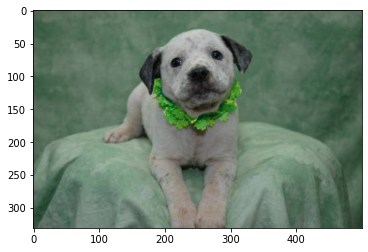

In [13]:
sample_one = random.choice(filenames)
image = load_img('/content/train/{}'.format(sample_one))
plt.imshow(image)

In [14]:
data_train['category1'] = data_train['category'].apply(lambda x: 'cat' if x== 0 else 'dog')
data_train.head()

,filename,category,category1
0,dog.9466.jpg,1,dog
1,dog.5329.jpg,1,dog
2,dog.1200.jpg,1,dog
3,dog.6042.jpg,1,dog
4,cat.3705.jpg,0,cat


In [15]:
data_train.drop(['category'] , inplace = True , axis = 1)
data_train.rename(columns  = {'category1' : 'category'} , inplace =True)
data_train.head()

,filename,category
0,dog.9466.jpg,dog
1,dog.5329.jpg,dog
2,dog.1200.jpg,dog
3,dog.6042.jpg,dog
4,cat.3705.jpg,cat


# Split data

In [16]:
train_df , val_df = train_test_split(data_train , test_size = 0.2 , random_state = 42)
train_df = train_df.reset_index(drop = True)
val_df = val_df.reset_index(drop = True)

In [17]:
train_df.shape , val_df.shape

((20000, 2), (5000, 2))

In [18]:
batch_size  = 15
epochs = 7
total_train = train_df.shape[0]
total_validate = val_df.shape[0]

# Image Augmentation

In [19]:
train_dategen = ImageDataGenerator(rotation_range = 15 , 
                                  rescale = 1.0/255 ,
                                  shear_range = 0.1,
                                  zoom_range = 0.2 , 
                                  horizontal_flip = True , 
                                  width_shift_range = 0.1 , 
                                  height_shift_range = 0.1
                                  )

In [20]:
train_generator = train_dategen.flow_from_dataframe(
    train_df, 
    "/content/train", 
    x_col='filename',
    y_col='category',
    target_size=Image_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle = True
)  

Found 20000 validated image filenames belonging to 2 classes.


In [21]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = validation_datagen.flow_from_dataframe(
    val_df, 
    "/content/train", 
    x_col='filename',
    y_col='category',
    target_size=Image_size,
    class_mode='categorical',
    batch_size=batch_size)  

Found 5000 validated image filenames belonging to 2 classes.


In [22]:
base_line = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=Image_rgb_size)

94765736/94765736 [==============================] - 5s 0us/step


In [23]:
x = base_line.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(2, activation= 'softmax')(x)
model = Model(inputs = base_line.input, outputs = predictions)

# Modelling data


In [24]:
adam = Adam(learning_rate=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [26]:
earlystop = EarlyStopping(patience = 10)
lr_reduc = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop , lr_reduc]

In [27]:
with tf.device("/device:GPU:0"):
  history = model.fit(
      train_generator , 
      epochs = epochs , 
      validation_data=val_generator,
      validation_steps=total_validate//batch_size,
      steps_per_epoch=total_train//batch_size,
      callbacks=callbacks
      )

Epoch 1/7
1333/1333 [==============================] - ETA: 0s - loss: 0.2402 - accuracy: 0.9068

1333/1333 [==============================] - 176s 121ms/step - loss: 0.2402 - accuracy: 0.9068 - val_loss: 0.0791 - val_accuracy: 0.9684 - lr: 1.0000e-04
Epoch 2/7
1333/1333 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9538

1333/1333 [==============================] - 164s 123ms/step - loss: 0.1164 - accuracy: 0.9538 - val_loss: 0.0871 - val_accuracy: 0.9656 - lr: 1.0000e-04
Epoch 3/7
1333/1333 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9626

1333/1333 [==============================] - 161s 121ms/step - loss: 0.0981 - accuracy: 0.9626 - val_loss: 0.0832 - val_accuracy: 0.9660 - lr: 1.0000e-04
Epoch 4/7
1333/1333 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9655

1333/1333 [==============================] - 157s 118ms/step - loss: 0.0879 - accuracy: 0.9655 - val_loss: 0.0799 - val_accuracy: 0.9696 - lr: 1.0000e-04
Epoch 5/7
1333/1333 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9689

1333/1333 [==============================] - 155s 117ms/step - loss: 0.0822 - accuracy: 0.9689 - val_loss: 0.1083 - val_accuracy: 0.9608 - lr: 1.0000e-04
Epoch 6/7
1333/1333 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9697

1333/1333 [==============================] - 155s 117ms/step - loss: 0.0791 - accuracy: 0.9697 - val_loss: 0.1040 - val_accuracy: 0.9586 - lr: 1.0000e-04
Epoch 7/7
1333/1333 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9734

1333/1333 [==============================] - 156s 117ms/step - loss: 0.0690 - accuracy: 0.9734 - val_loss: 0.0874 - val_accuracy: 0.9664 - lr: 1.0000e-04


In [28]:
model.save_weights('model.h5')

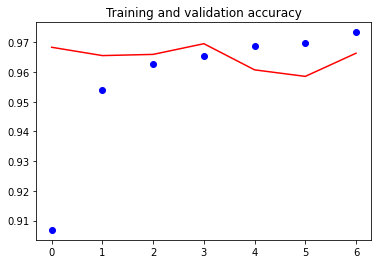

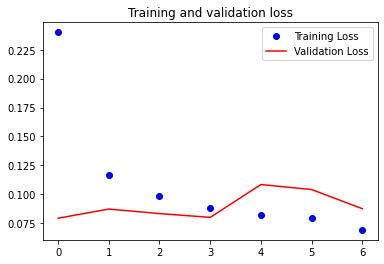

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
#test_filenames = os.listdir('/content/test1')
#data_test = pd.DataFrame({'filename' : test_filenames})
#nb_samples = test.shape[0]

In [31]:
#data_test.head()

In [32]:
#test_gen = ImageDataGenerator(rescale=1./255)
#test_generator = test_gen.flow_from_dataframe(
    #test , 
    #'/content/test1' ,
    #x_col='filename',
    #y_col=None,
    #class_mode=None,
    #target_size=Image_size,
    #batch_size=batch_size,
    #shuffle=False
    #)

In [33]:
#predict = model.predict(test_generator , steps = np.ceil(nb_samples/batch_size))
#data_test['category'] = np.argmax(predict  , axis= -1)
#data_test.head()

In [34]:
#image = load_img('/content/test1/{}'.format('1366.jpg'))
#plt.imshow(image)

In [35]:
#sns.countplot(test['category'])

# Deploy model

In [36]:
# Save model into SavedModel format
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
# Convert SavedModel to vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

93985092

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.pb') 
%cd